In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from mm.neural.neural import *
from layers import *
from network import *
from neural import *

In [2]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)

Common init:         -------------------------- 2023-07-24 16:47:29
dtype:               torch.float32
device:              cpu
contextSize:         3


In [3]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:        -------------------------- 2023-07-24 16:47:29
filePath:            ../../data/names.txt
First few words:     ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:        32033
Vocabulary:          ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:  3.2958


In [4]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:     -------------------------- 2023-07-24 16:47:29
wordShufflingSeed:   42
data dtype:          torch.int64
trRatio:             0.8
devRatio:            0.9
Training:            length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:          length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [5]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 100
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dtype, dvc)
printNetworkInfo(np)
    
@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:       -------------------------- 2023-07-24 16:47:30
embeddingDims:       10
hiddenLayerSize:     100
learningSeed:        2147483647
Network Structure:  
Layer LinearWithBias 1: [30, 100]; [100]; 
Layer Tanh 2: 
Layer LinearWithBias 3: [100, 100]; [100]; 
Layer Tanh 4: 
Layer LinearWithBias 5: [100, 100]; [100]; 
Layer Tanh 6: 
Layer LinearWithBias 7: [100, 100]; [100]; 
Layer Tanh 8: 
Layer LinearWithBias 9: [100, 100]; [100]; 
Layer Tanh 10: 
Layer LinearWithBias 11: [100, 27]; [27]; 
Parameters Count:    46497


In [6]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 2000
log("maxIteration", maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = True;

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
i = 0
for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    #logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("Break at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.layers, np.parameters, fr.loss)

        up = updateNet(np.parameters, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        i += 1

logSimple(f" final losses: {fr.loss.item():>15.4f}   ", end="")
#logLosses()

log("emb.shape", fr.emb.shape)
log("logits.shape", fr.logits.shape)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = False;

Learning:            -------------------------- 2023-07-24 16:47:30
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        2000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    2000
  0,      0 losses:     0.0000   Break at max iteration:
 final losses:          2.8056   emb.shape:           [32, 3, 10]
logits.shape:        [32, 27]


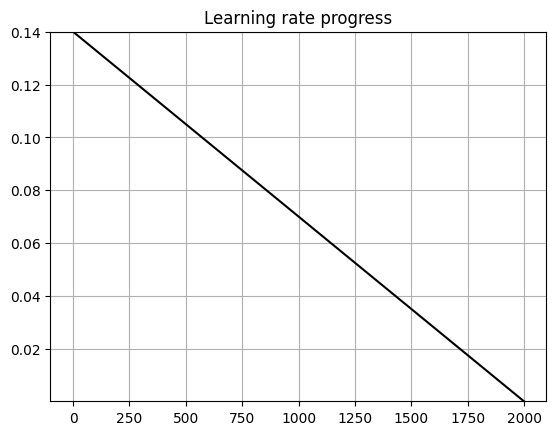

Min learning rate:   0.0001699499999999743
Max learning rate:   0.14


In [7]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.title('Learning rate progress');
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
log("Min learning rate", min(lrAtIx))
log("Max learning rate", max(lrAtIx))


  Tanh 2:            mean: +0.97, std: +0.02, saturated: 66.56
  Tanh 4:            mean: +1.00, std: +0.00, saturated: 100.00
  Tanh 6:            mean: +1.00, std: +0.00, saturated: 100.00
  Tanh 8:            mean: +1.00, std: +0.00, saturated: 100.00
  Tanh 10:           mean: +1.00, std: +0.00, saturated: 100.00


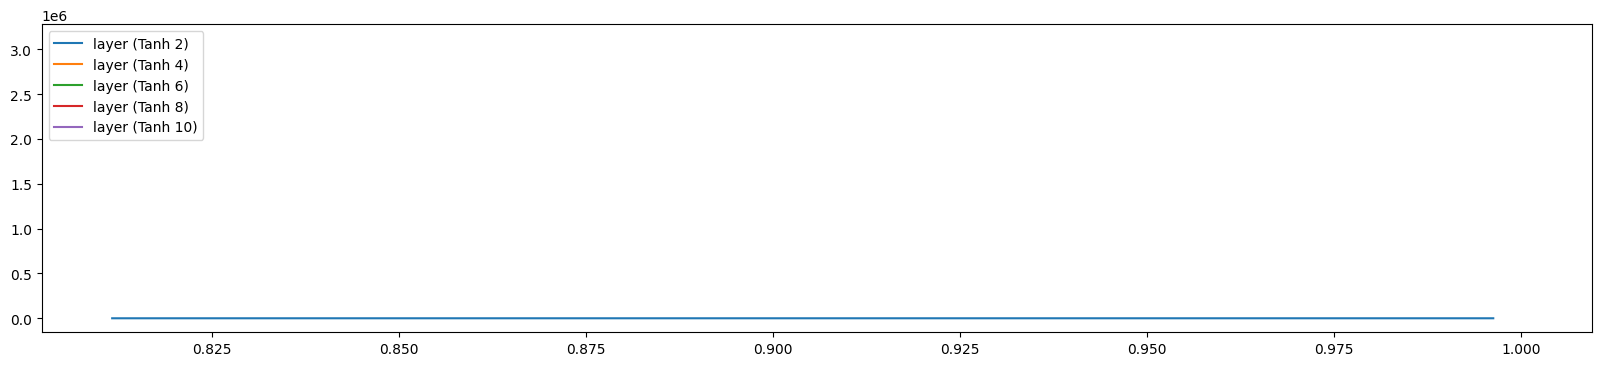

In [8]:
plotActivationsDistribution(np, Tanh)


  LinearWithBias 1:  mean: +2.28477, std: +0.39512, saturated: 100.00
  LinearWithBias 3:  mean: +8.09117, std: +0.46273, saturated: 100.00
  LinearWithBias 5:  mean: +8.34595, std: +0.42428, saturated: 100.00
  LinearWithBias 7:  mean: +8.31075, std: +0.47966, saturated: 100.00
  LinearWithBias 9:  mean: +8.36438, std: +0.47567, saturated: 100.00
  LinearWithBias 11: mean: +0.50225, std: +1.24875, saturated: 51.85


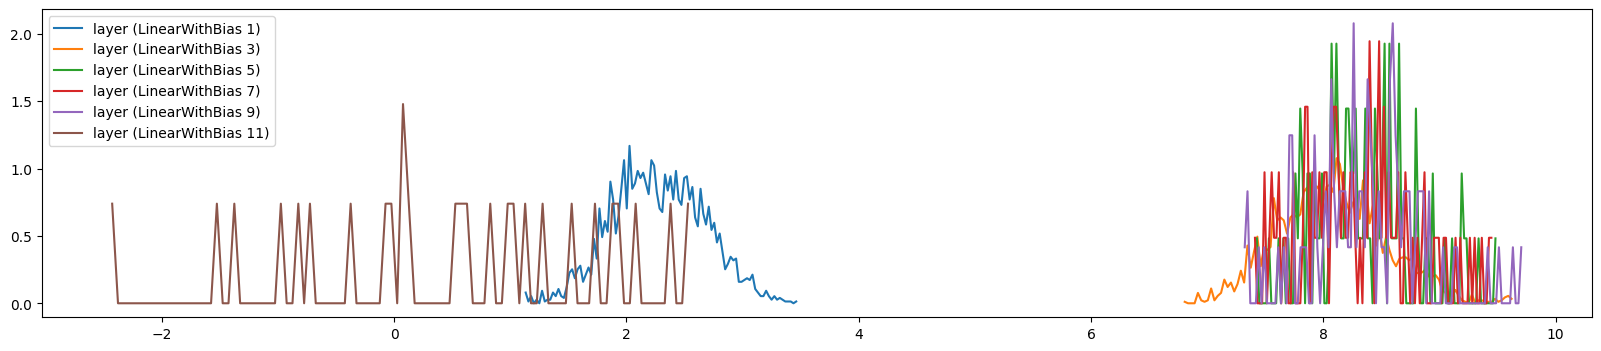

In [16]:
plotActivationsDistribution(np, LinearWithBias)

layer (    Tanh 2): mean +0.000000, std 2.784830e-26
layer (    Tanh 4): mean +0.000000, std 5.653471e-21
layer (    Tanh 6): mean +0.000000, std 2.319893e-15
layer (    Tanh 8): mean +0.000000, std 8.217239e-10
layer (   Tanh 10): mean +0.000002, std 3.230996e-04


Text(0.5, 1.0, 'Gradient distribution')

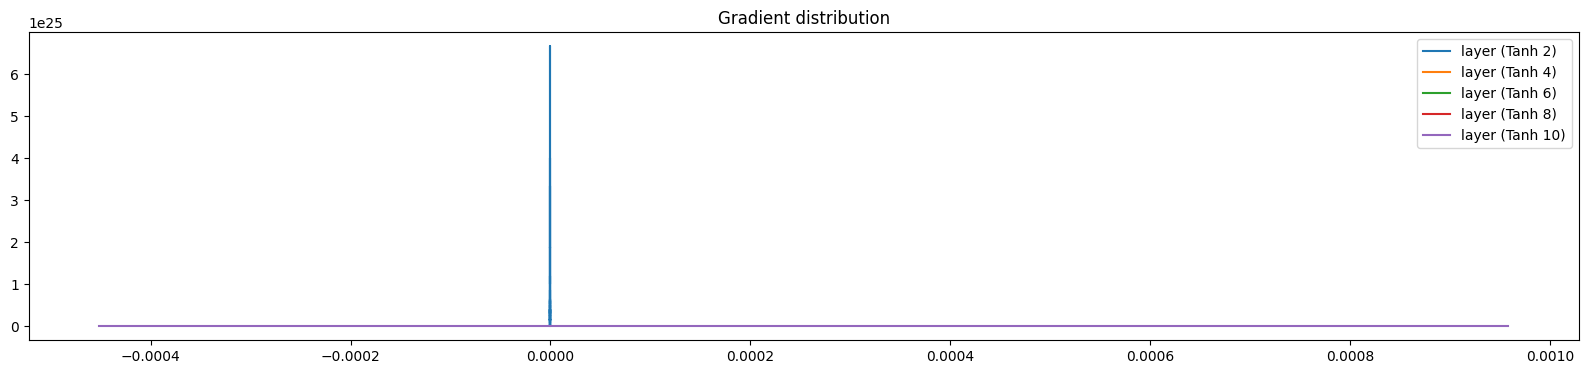

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for l in np.layers[:-1]: # note: exclude the output layer
  if isinstance(l, Tanh):
    t: Tensor = l.out.grad # type: ignore
    print('layer (%10s): mean %+f, std %e' % (l.name, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer ({l.name})')
plt.legend(legends);
plt.title('Gradient distribution')

Activation distribution - Tanh (Grad)
  Tanh 2:            mean: +0.00, std: +0.00, saturated: 0.00
  Tanh 4:            mean: +0.00, std: +0.00, saturated: 0.00
  Tanh 6:            mean: +0.00, std: +0.00, saturated: 0.00
  Tanh 8:            mean: +0.00, std: +0.00, saturated: 0.00
  Tanh 10:           mean: +0.00, std: +0.00, saturated: 0.00


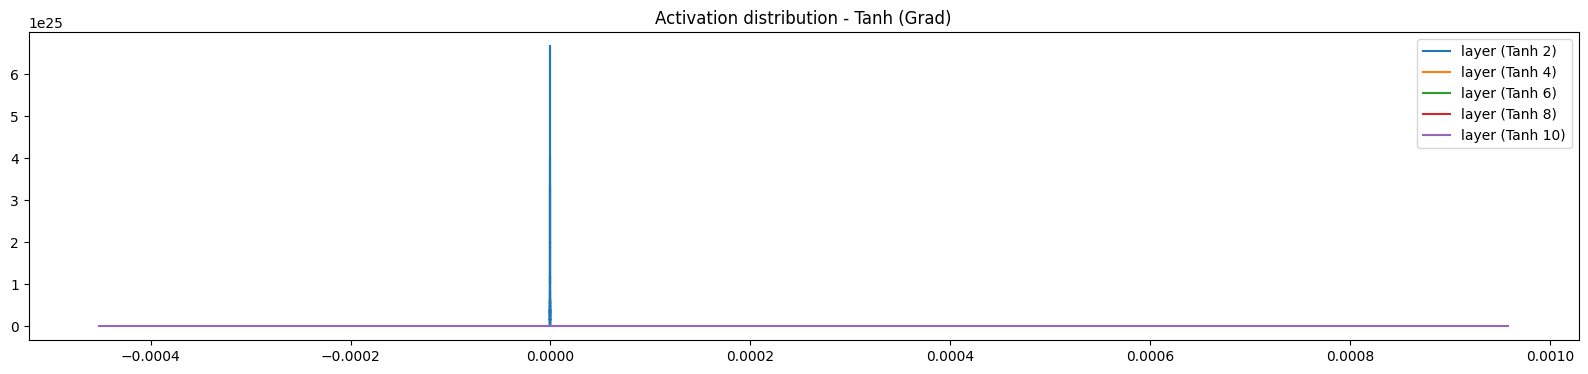

In [11]:
plotActivationsDistribution(np, Tanh, useGrad=True)

Activation distribution - LinearWithBias (Grad)
  LinearWithBias 1:  mean: +0.00000, std: +0.00000, saturated: 0.00
  LinearWithBias 3:  mean: +0.00000, std: +0.00000, saturated: 0.00
  LinearWithBias 5:  mean: +0.00000, std: +0.00000, saturated: 0.00
  LinearWithBias 7:  mean: +0.00000, std: +0.00000, saturated: 0.00
  LinearWithBias 9:  mean: +0.00000, std: +0.00000, saturated: 0.00
  LinearWithBias 11: mean: +0.00000, std: +0.00574, saturated: 0.00


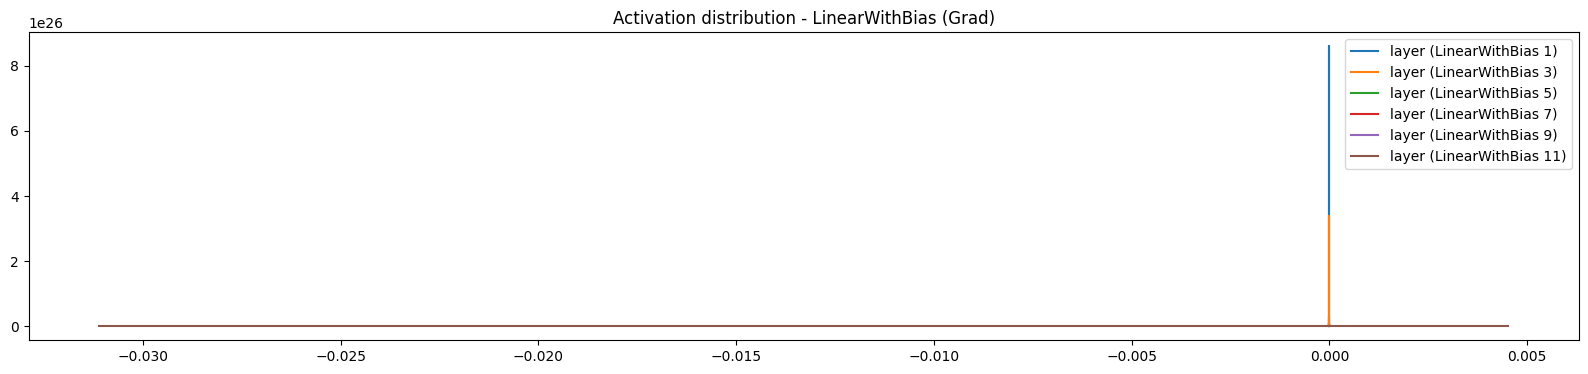

In [15]:
plotActivationsDistribution(np, LinearWithBias, useGrad=True)

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

AttributeError: 'ForwardPassResult' object has no attribute 'h'

<Figure size 2000x1000 with 0 Axes>

In [ ]:
def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<21}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

.                    1443   : 39 
m.                   108    : 8 39 
mi.                  64     : 8 21 39 
mic.                 32     : 8 21 4 39 
mich.                25     : 8 21 4 9 39 
micha.               28     : 8 21 4 9 41 39 
michal.              26     : 8 21 4 9 41 16 39 
michael.             26     : 8 21 4 9 41 24 16 39 
michaela.            27     : 8 21 4 9 41 24 16 41 39 
michaella.           26     : 8 21 4 9 41 24 16 16 41 39 
michel.              24     : 8 21 4 9 24 16 39 
michalx.             17     : 8 21 4 9 41 16 1 39 
michalxx.            12     : 8 21 4 9 41 16 1 1 39 
michalxxx.           9      : 8 21 4 9 41 16 1 1 1 39 
martin.              31     : 8 41 15 6 21 21 39 
andrej.              117    : 41 21 6 15 24 3 39 
andrey.              140    : 41 21 6 15 24 12 39 
joey.                14     : 3 9 24 12 39 
james.               14     : 3 41 8 24 10 39 
xin.                 5      : 1 21 21 39 
maxim.               21     : 8 41 1 21 8 39 
alex.    

In [ ]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:            -------------------------- 2023-07-24 14:18:55
samplingSeed:        2147483657
maxSampleLength:     50


In [ ]:
samples = sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

ernaaimyaahreelmnd.    71: 24 15 21 41 41 21 8 12 41 41 9 15 24 24 16 8 21 6 39 
ryal.                  77: 15 12 41 16 39 
rethrsjejdrleg.        26: 15 24 6 9 15 10 3 24 3 6 15 16 24 2 39 
adeeedieliihemi.      113: 41 6 24 24 24 6 21 24 16 21 21 9 24 8 21 39 
realeieiseananarneatzimhlkaa.  43: 15 24 41 16 24 21 24 21 10 24 41 21 41 21 41 15 21 24 41 6 3 21 8 9 16 6 41 41 39 
n.                    301: 21 39 
sadbvrgahimies.        20: 10 41 6 3 3 15 2 41 9 21 8 21 24 10 39 
.                    1443: 39 
n.                    301: 21 39 
ir.                   154: 21 15 39 
eelklxnteuoanu.        45: 24 24 16 6 16 1 21 6 24 4 9 41 21 4 39 
amnedar.              141: 41 8 21 24 6 41 15 39 
yihle.                 48: 12 21 9 16 24 39 
ehs.                  102: 24 9 10 39 
laajaysknyaa.          52: 16 41 41 3 41 12 10 6 21 12 41 41 39 
hia.                   69: 9 21 41 39 
nalyaisun.             69: 21 41 16 12 41 21 10 4 21 39 
zajelveuren.            7: 3 41 3 24 16 3 24 4 15 24 2

In [ ]:
if newNet:
    pass
else:
    fig, ax = plt.subplots()
    fig.set_facecolor("#777777")
    ax.set_facecolor("#222222")
    #ax.plot(lrAtIx, lossAtIx)
    plt.show()

In [ ]:
if newNet:
    pass
else:
    fig, ax = plt.subplots()
    fig.set_facecolor("#777777")
    ax.set_facecolor("#222222")
    ax.plot(stepIx, lossAtIx)
    plt.show()

In [ ]:
if newNet:
    pass
else:
    fig, ax = plt.subplots()
    fig.set_facecolor("#777777")
    ax.set_facecolor("#222222")
    ax.plot(stepIx, logLossAtIx)
    plt.show()

In [ ]:
if newNet:
    pass
else:
    dim = 0
    fig = plt.figure(figsize=(8,8))
    fig.set_facecolor("#777777")
    sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
    for i in range(np.C.shape[0]):
        plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid()

In [ ]:
#np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

In [ ]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
